In [1]:
from cond_rnn import ConditionalRNN
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
import pandas as pd
import math
import numpy as np

In [2]:
# import data
import pickle
with open("datasets2.pickle", "rb") as handle:
    input_data_shiftedy = pickle.load(handle)
# select only n, daily asthma visits and total, daily total AE visits, 
# comment out if including air pollution station data
first_col = input_data_shiftedy.n / input_data_shiftedy.total * 1000
input_data_shiftedy.insert(0, "prevalence", first_col)
input_data_shiftedy = input_data_shiftedy.drop(["n", "total", "y"], axis = 1)
# input_data_shiftedy = pd.concat([input_data_shiftedy.n.reset_index(drop = True), 
#                         input_data_shiftedy.total.reset_index(drop = True)], axis = 1)

In [3]:
input_data_shiftedy.head()

,prevalence,Mean (deg. C),Mean Relative Humidity (%),CO_CENTRAL,CO_MONG KOK,CO_TSUEN WAN,CO_TUEN MUN,CO_TUNG CHUNG,CO_YUEN LONG,FSP_CAUSEWAY BAY,...,SO2_KWAI CHUNG,SO2_KWUN TONG,SO2_MONG KOK,SO2_SHAM SHUI PO,SO2_SHATIN,SO2_TAI PO,SO2_TSUEN WAN,SO2_TUEN MUN,SO2_TUNG CHUNG,SO2_YUEN LONG
0,7.133378,16.0,61,78.791667,96.583333,80.291667,92.875000,62.875000,113.875000,51.916667,...,21.869565,15.913043,14.375000,14.166667,12.347826,7.458333,19.000000,17.458333,19.916667,13.166667
1,7.358462,15.2,71,91.500000,110.375000,89.416667,91.250000,75.625000,107.125000,67.208333,...,17.500000,16.208333,13.250000,13.541667,14.583333,10.666667,17.791667,17.708333,17.625000,14.666667
2,5.601793,15.5,65,67.875000,93.541667,72.125000,69.625000,55.333333,95.833333,38.708333,...,13.458333,13.291667,10.583333,10.166667,10.041667,6.750000,17.291667,15.750000,18.583333,10.750000
3,7.155907,17.3,78,70.791667,100.833333,62.250000,68.583333,48.130435,86.208333,41.333333,...,10.625000,10.708333,8.125000,7.916667,7.375000,5.583333,15.958333,15.500000,19.869565,8.958333
4,9.012757,19.0,81,83.875000,104.500000,65.625000,68.916667,46.500000,82.833333,42.875000,...,9.166667,4.958333,6.208333,5.958333,6.833333,4.041667,10.166667,21.791667,14.400000,5.166667


In [376]:
asthma_weekly = pd.read_excel("asthma.weekly.severe.xlsx",
                            engine = "openpyxl")

In [377]:
asthma_weekly = asthma_weekly.sort_values(by = ["year", "week"])

In [378]:
asthma_weekly = asthma_weekly[asthma_weekly.groupby("year").cumcount(ascending=False) > 0]

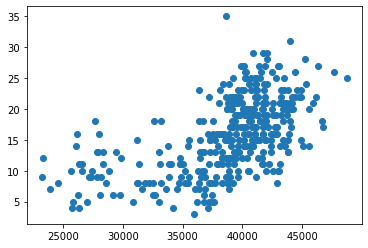

In [379]:
plt.scatter(asthma_weekly.total, asthma_weekly.n)

In [380]:
input_data_shiftedy = asthma_weekly
input_data_shiftedy = pd.concat([input_data_shiftedy.n.reset_index(drop = True), 
                        input_data_shiftedy.total.reset_index(drop = True)], axis = 1)

In [5]:
input_data_shiftedy.head()

,prevalence,Mean (deg. C),Mean Relative Humidity (%),CO_CENTRAL,CO_MONG KOK,CO_TSUEN WAN,CO_TUEN MUN,CO_TUNG CHUNG,CO_YUEN LONG,FSP_CAUSEWAY BAY,...,SO2_KWAI CHUNG,SO2_KWUN TONG,SO2_MONG KOK,SO2_SHAM SHUI PO,SO2_SHATIN,SO2_TAI PO,SO2_TSUEN WAN,SO2_TUEN MUN,SO2_TUNG CHUNG,SO2_YUEN LONG
0,7.133378,16.0,61,78.791667,96.583333,80.291667,92.875000,62.875000,113.875000,51.916667,...,21.869565,15.913043,14.375000,14.166667,12.347826,7.458333,19.000000,17.458333,19.916667,13.166667
1,7.358462,15.2,71,91.500000,110.375000,89.416667,91.250000,75.625000,107.125000,67.208333,...,17.500000,16.208333,13.250000,13.541667,14.583333,10.666667,17.791667,17.708333,17.625000,14.666667
2,5.601793,15.5,65,67.875000,93.541667,72.125000,69.625000,55.333333,95.833333,38.708333,...,13.458333,13.291667,10.583333,10.166667,10.041667,6.750000,17.291667,15.750000,18.583333,10.750000
3,7.155907,17.3,78,70.791667,100.833333,62.250000,68.583333,48.130435,86.208333,41.333333,...,10.625000,10.708333,8.125000,7.916667,7.375000,5.583333,15.958333,15.500000,19.869565,8.958333
4,9.012757,19.0,81,83.875000,104.500000,65.625000,68.916667,46.500000,82.833333,42.875000,...,9.166667,4.958333,6.208333,5.958333,6.833333,4.041667,10.166667,21.791667,14.400000,5.166667


In [4]:
int(len(input_data_shiftedy) * .8)

1861

In [6]:
# scaling fit with train-test split consideration to avoid data leakage
# may need verification
from sklearn.preprocessing import StandardScaler, Normalizer

# number of time steps for sequence learning
n_steps_x = 14
# number of time steps for sequence prediction
n_steps_y = 7

split_at = int(len(input_data_shiftedy) * .8)
val_split_at = int(len(input_data_shiftedy) * .9)

scaler = StandardScaler()
# fit by training set only
input_data_shiftedy.iloc[:(split_at + n_steps_x + n_steps_y),1:] = scaler.fit_transform(
    input_data_shiftedy.iloc[:(split_at + n_steps_x + n_steps_y),1:])
# only transform valid and testing sets
input_data_shiftedy.iloc[(split_at + n_steps_x + n_steps_y):,1:] = scaler.transform(
    input_data_shiftedy.iloc[(split_at + n_steps_x + n_steps_y):,1:])

In [7]:
def reshape_sliding1(X, num_steps_x = 2, num_steps_y = 2):
    X = pd.DataFrame(X)
    X_transformed = [np.array(X.shift(i)) for i in range(num_steps_x + num_steps_y)]
    X_transformed = np.dstack(X_transformed)
    
    # swap time steps and dimensionality axes
    X_transformed = np.swapaxes(X_transformed, 1, 2)
    # flip time steps axis
    X_transformed = np.flip(X_transformed, 1)
    X_transformed = X_transformed[(num_steps_x+num_steps_y - 1):]
    return X_transformed

In [8]:

input_data_shiftedy = reshape_sliding1(input_data_shiftedy, 
                                       num_steps_x = n_steps_x,
                                      num_steps_y = n_steps_y)

In [9]:
# train_test_split 

X_train = input_data_shiftedy[:split_at, :n_steps_x, :]
X_valid = input_data_shiftedy[split_at:val_split_at, :n_steps_x, :]
X_test = input_data_shiftedy[val_split_at:, :n_steps_x, :]

Y = np.empty((input_data_shiftedy.shape[0], n_steps_x, n_steps_y))
for step_ahead in range(1, n_steps_y + 1):
    Y[..., step_ahead - 1] = input_data_shiftedy[..., step_ahead:step_ahead + n_steps_x, 0]
Y_train = Y[:split_at]
Y_valid = Y[split_at:val_split_at]
Y_test = Y[val_split_at:]

In [10]:
# # optional
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# checking dimensionality
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
assert X_train.shape[1:] == X_valid.shape[1:]
assert Y_train.shape[1:] == Y_valid.shape[1:]

(1861, 14, 92) (1861, 14, 7) (233, 14, 92) (233, 14, 7)


# modelling
1. as of 23rd aug 2022: rnn loss nan problem <br>
possible remedies: normalize data, regularization, increase batch size <br>
https://datascience.stackexchange.com/questions/68331/keras-sequential-model-returns-loss-nan <br>
2. as of 24th aug 2022: try to add overall AE visit to include hospital avoidance effect
3. as of 25th aug 2022: corrected reshaping problem, performance is still shit, try remove air pollution, try larger learning rate
4. as of 26th aug 2022: try seq2seq model, it worked 
5. from the results it seems most contributing factor is total AE trend 


In [12]:
from tensorflow import keras
import tensorflow as tf

In [13]:
optimizer = keras.optimizers.Adam(clipvalue = 1)

In [14]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [57]:
# simplified wavenet
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [None, X_train.shape[2]]))
for rate in (1, 2, 4, 8, 16) * 2:
    model.add(keras.layers.Conv1D(filters = 100, kernel_size = 2, padding = "causal",
                                 activation = "relu", dilation_rate = rate))
model.add(keras.layers.Conv1D(filters = Y_train.shape[2], kernel_size = 1))
model.compile(loss = "mse", optimizer = optimizer, metrics = [last_time_step_mse])

In [58]:
history = model.fit(X_train, Y_train, epochs=30,
                    validation_data=(X_valid, Y_valid),
                    callbacks = [callback]
                   )

Epoch 1/30
59/59 [==============================] - 3s 21ms/step - loss: 6.7003 - last_time_step_mse: 9.1828 - val_loss: 1.4291 - val_last_time_step_mse: 1.2083
Epoch 2/30
59/59 [==============================] - 1s 18ms/step - loss: 1.3432 - last_time_step_mse: 1.2952 - val_loss: 1.8626 - val_last_time_step_mse: 1.6269
Epoch 3/30
59/59 [==============================] - 1s 16ms/step - loss: 1.3087 - last_time_step_mse: 1.2627 - val_loss: 1.5947 - val_last_time_step_mse: 1.3856
Epoch 4/30
59/59 [==============================] - 1s 15ms/step - loss: 1.2723 - last_time_step_mse: 1.2261 - val_loss: 1.7652 - val_last_time_step_mse: 1.5119


In [36]:
# inference 
import matplotlib.pyplot as plt

In [59]:
pred = model.predict(X_test)

In [60]:
assert pred.shape == Y_test.shape

In [121]:
print(pred.shape)

(213, 14, 7)


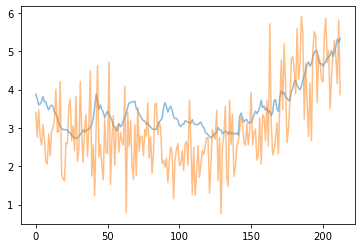

In [62]:
plt.plot(np.double(pred[:, -1, -1]).flatten(), alpha = .5)
plt.plot(np.double(Y_test[:, -1, -1]).flatten(), alpha = .5)

In [63]:
def last_time_step_mse_total(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1, -1], Y_pred[:, -1, -1])
last_time_step_mse_total(Y_test, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9120207>

In [23]:
pred = model.predict(X_valid)

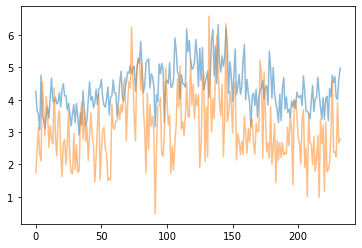

In [24]:
plt.plot(np.double(pred[:, 0, -1]).flatten(), alpha = .5)
plt.plot(np.double(Y_valid[:, 0, -1]).flatten(), alpha = .5)

In [107]:
pred.shape

(213, 14, 7)

# shap value

In [111]:
import shap

In [112]:
def f(X):
    return model.predict(X)[:, -1, -1]

In [115]:
explainer = shap.KernelExplainer(f, X_test[:50])

In [119]:
explainer = shap.DeepExplainer(model, X_test[:50])

AssertionError: The model output must be a vector or a single value!

In [117]:
X_test[:50, -1, :].shape

(50, 92)

In [118]:
shap_values = explainer.shap_values(X_test[:50])

AssertionError: Instance must have 1 or 2 dimensions!

In [98]:
X_test[:, -1, :].shape

(213, 92)